In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy import spatial
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [51]:
liked_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/liked/songs.parquet')
discover_weekly = pd.read_parquet('datasets/cleaned/music-recommendation-system/unheard/discover-weekly.parquet')
unheard_songs = pd.read_parquet('datasets/cleaned/music-recommendation-system/unheard/songs.parquet')
df = pd.concat([liked_songs, discover_weekly[discover_weekly['like'].notnull()]], ignore_index=True)
df['listen'] = df['listen'].astype(int)
df['like'] = df['like'].astype(int)

In [7]:
tobe_standardized_columns = [
  'popularity', 'danceability', 'energy',
  'key', 'loudness', 'mode', 'speechiness', 
  'acousticness', 'instrumentalness', 'liveness', 
  'valence', 'tempo', 'duration_ms', 
  'time_signature'
]

In [85]:
scaler = StandardScaler()

unstandardized_favorite_songs_df = df[tobe_standardized_columns].copy()
standardized_favorite_songs_values = scaler.fit_transform(unstandardized_favorite_songs_df)

In [86]:
# put the standardized data back into a dataframe, as well as the `id` column back
standardized_favorite_songs_df = pd.DataFrame(standardized_favorite_songs_values, columns=tobe_standardized_columns)
standardized_favorite_songs_df['id'] = df['id']
standardized_favorite_songs_df['listen'] = df['listen']
standardized_favorite_songs_df = standardized_favorite_songs_df[['id'] + tobe_standardized_columns + ['listen']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(standardized_favorite_songs_df[tobe_standardized_columns], df['like'], test_size=0.3, random_state=42)

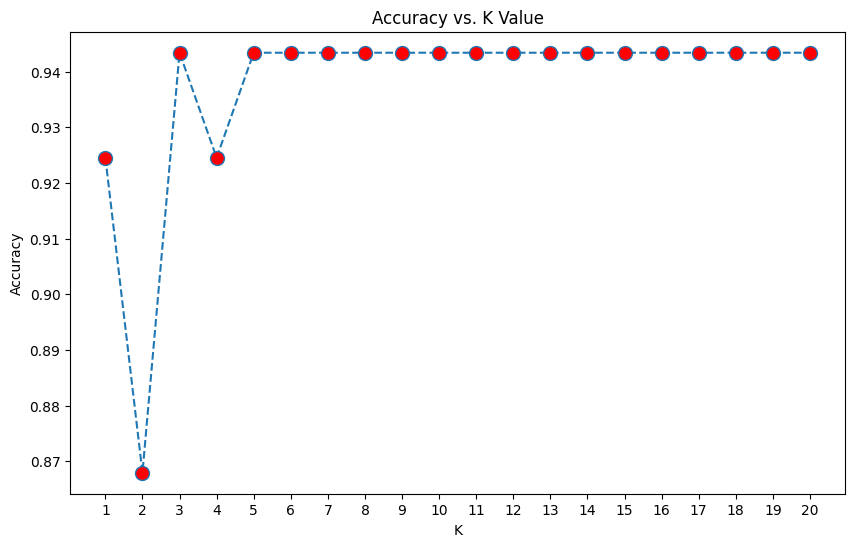

In [34]:
neighbors = np.arange(1, 21, 1)
accuracy = list()

for n in neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(neighbors, accuracy, linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.xticks(neighbors)
plt.ylabel('Accuracy')
plt.show()

In [35]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Accuracy: {}'.format(knn.score(X_test, y_test)))

Accuracy: 0.9433962264150944


In [39]:
unheard_notliked_songs = unheard_songs[unheard_songs['like'].isnull()]

In [52]:
unstandardized_unheard_notliked_songs_df = unheard_notliked_songs[tobe_standardized_columns].copy()
standardized_unheard_notliked_songs_values = scaler.fit_transform(unstandardized_unheard_notliked_songs_df)
standardized_unheard_notliked_songs_df = pd.DataFrame(standardized_unheard_notliked_songs_values, columns=tobe_standardized_columns)
standardized_unheard_notliked_songs_df['id'] = unheard_notliked_songs['id']
standardized_unheard_notliked_songs_df['listen'] = unheard_notliked_songs['listen']
standardized_unheard_notliked_songs_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,listen
0,1.175163,-0.815145,0.733784,0.224747,0.189932,-1.372581,-0.291709,-0.766357,-0.335930,1.223364,0.080875,1.959752,0.524358,0.213602,6ZZf5a8oiInHDkBe9zXfLP,0
1,0.762717,1.532085,0.571000,-1.183632,0.485082,0.728555,-0.477889,-0.893541,-0.335926,-0.788442,2.391734,-0.228800,-0.762322,0.213602,3FyfTh70PkgooRDe4SNP0U,0
2,1.484497,0.613904,0.390128,-1.465307,0.905067,0.728555,-0.090359,-0.877643,-0.335917,-1.090570,0.969330,-0.156205,0.025952,0.213602,4DHcnVTT87F0zZhRPYmZ3B,0
3,0.917384,-0.193819,0.390128,-0.056929,-0.051027,0.728555,-0.590976,-0.931260,-0.335584,-0.132643,-1.540227,0.136695,-0.477717,0.213602,1rBTBbtkJlSDk78gg8Dw9F,0
4,0.608051,-0.483771,-0.545880,0.788099,-0.520043,0.728555,-0.396522,0.755170,-0.335942,-0.386398,-0.715671,-0.083646,-0.578365,0.213602,3DBJE1Zndql25OGUQSv7aD,0


In [48]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(standardized_unheard_notliked_songs_df[tobe_standardized_columns])
unheard_notliked_songs['like'] = y_pred

In [49]:
unheard_notliked_songs['like'].value_counts()

1    1012
0      32
Name: like, dtype: int64

In [50]:
unheard_notliked_songs.to_parquet('datasets/cleaned/music-recommendation-system/dislike/songs.parquet', index=False)

In [63]:
# get the index value of the songs that like == 0 
unheard_notliked_songs[unheard_notliked_songs['like'] == 0].index

Int64Index([  10,   53,   58,  103,  140,  142,  236,  252,  258,  294,  414,
             451,  493,  515,  741,  798,  814,  826,  833,  916,  945,  948,
             964,  965,  966,  976, 1009, 1019, 1025, 1026, 1027, 1037],
           dtype='int64')

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

dislike_song_ids = [  10,   53,   58,  103,  140,  142,  236,  252,  258,  294,  414,
             451,  493,  515,  741,  798,  814,  826,  833,  916,  945,  948,
             964,  965,  966,  976, 1009, 1019, 1025, 1026, 1027, 1037]

# get the cosine similarity matrix, excluding the ids in dislike_song_ids
cosine_sim_matrix = cosine_similarity(standardized_favorite_songs_values, standardized_unheard_notliked_songs_values[~standardized_unheard_notliked_songs_df.index.isin(dislike_song_ids)])

In [89]:
cosine_sim_matrix[:10]

array([[-0.13844482, -0.11507174, -0.23543195, ..., -0.47516885,
        -0.22624599,  0.15026421],
       [ 0.24608324, -0.31672802, -0.32489089, ..., -0.46172093,
         0.01666095, -0.23238758],
       [ 0.25597107, -0.34985527, -0.3193678 , ..., -0.70763744,
        -0.1586914 ,  0.44039179],
       ...,
       [-0.15018148, -0.36368659, -0.48589837, ..., -0.42301055,
        -0.03110198,  0.03037939],
       [ 0.07095339, -0.45917758, -0.42530403, ..., -0.57960734,
        -0.14037412,  0.07676045],
       [ 0.01343401, -0.51785812, -0.52022316, ..., -0.42874138,
        -0.03814977,  0.27877034]])

In [90]:
similarity_scores = cosine_sim_matrix[:10]
print(similarity_scores)

[[-0.13844482 -0.11507174 -0.23543195 ... -0.47516885 -0.22624599
   0.15026421]
 [ 0.24608324 -0.31672802 -0.32489089 ... -0.46172093  0.01666095
  -0.23238758]
 [ 0.25597107 -0.34985527 -0.3193678  ... -0.70763744 -0.1586914
   0.44039179]
 ...
 [-0.15018148 -0.36368659 -0.48589837 ... -0.42301055 -0.03110198
   0.03037939]
 [ 0.07095339 -0.45917758 -0.42530403 ... -0.57960734 -0.14037412
   0.07676045]
 [ 0.01343401 -0.51785812 -0.52022316 ... -0.42874138 -0.03814977
   0.27877034]]


In [91]:
top_indeces = similarity_scores.argsort()[::-1][:5]
print(top_indeces)

[[ 574   86  589 ...  415 1002  363]
 [ 574  277  274 ...  512  822  404]
 [ 192  373  863 ...  508  411  430]
 [ 192   86  863 ...  949  411  430]
 [ 529  559  583 ...   75  426  430]]


In [104]:
top_indeces[0].shape

(1012,)

In [105]:
top_indeces[0]

array([ 574,   86,  589, ...,  415, 1002,  363])

In [103]:
for index in top_indeces[:1]:
  print(unheard_notliked_songs.iloc[index][['title', 'artist(s)']][:15])

                                  title                    artist(s)
574                 If I Can't Have You                 Shawn Mendes
86               Before the Petals Fall                         CHEN
589                          Bad Habits                   Ed Sheeran
82                          Padam Padam                Kylie Minogue
559                           Attention                 Charlie Puth
555                         I Like That                        Bazzi
294                              willow                 Taylor Swift
938                              KILLKA    Ghostface Playa, fkbambam
760                                Hurt         Maikubi, VOLT VISION
529                                Blue                        Elina
568                        Side To Side                Ariana Grande
562                             Feather            Sabrina Carpenter
556                       Mad at Disney                  salem ilese
583  Baby, I'm Jealous (feat. Doja